In [47]:
#| default_exp fast_excel

In [117]:
#| echo: false
from fastcore.utils import *
import fastcore.all as fc, re, math, itertools, functools, numpy as np, types, typing, dataclasses, matplotlib.pyplot as plt, collections, regex
from dataclasses import dataclass
np.set_printoptions(linewidth=150, suppress=True)
plt.rcParams['figure.dpi'] = 50
import pandas as pd
from pathlib import Path
import ast
import pyxirr
%matplotlib inline

# Intro

In financial modelling there is a trade-off between complexity and granularity of a model and how quickly we are able to iterate and calculate different scenarios. Partially this can be solved by employing efficient model structure and VBA macros to calculate different scenarios or create sensitivity tables. 

VBA, although suitable for its purpose, is rather unflexible and sometimes it is a pain to write something more complex than simple procedures. Python, on the other hand, is __very__ flexible and boasts a huge number of libraries suited for all purposes from vizulization to running complex optimizations. There are also packages that allow to write python code directly in VBA but today we will explore another direction. 

We will export a simple DCF model from Excel to Python and recreate relations between variables that are of interest to us. Some variables (external data or plain user inputs) will be treated as constants, while other will be calculated based on excel formulas. To test this approach we create a very simple excel DCF model that calculates IRR and captures some important relations (price / volume, exchange rate, etc). Most of the inputs are treated as fixed as this stage (although they might still be the result of a complex calculation in excel) to be able to quickly iterate. Later we will extend our approach to deal with more complex model structure.

So before delving into the details, let's spell out our goal once more:

> Convert Excel financial model into a Python calculation engine by converting text formula descriptions (like `Revenue=Production*Netback Price`) into executable pandas operations.

# Part 1 - Exploration

First we load our simple excel model in pandas dataframe. Column `Formula` contains a formula used to calculate a given row. For example `Revenue` is calculated as `Production * Netback Price`. This means that in Python that row shall be calculated by multiplying row `Production` by row `Netback Price`. If formula is a `Constant`, then no operation is applied. For ease of access we separate numerical data (`data` dataframe) from metadata (`metadata` dataframe).

Let's check our `data` frame.

In [68]:
path = Path("SimpleModel_v0.xlsm")
mdl = pd.read_excel(path, sheet_name="mdl", header=2, index_col=1)

unnamed_cols = [col for col in mdl.columns if col.startswith('Unnamed')]
mdl = mdl.drop(columns=unnamed_cols)

metadata_cols = ['Units', 'Formula']
data_cols = [col for col in mdl.columns if col not in metadata_cols]

# Create clean data matrix with only numeric values
data = mdl[data_cols].copy() 
metadata = mdl[metadata_cols].copy()

In [67]:
#|echo: false
data.iloc[:10][data.columns[30:45]]

,2Q 2027,3Q 2027,4Q 2027,1Q 2028,2Q 2028,3Q 2028,4Q 2028,1Q 2029,2Q 2029,3Q 2029,4Q 2029,1Q 2030,2Q 2030,3Q 2030,4Q 2030
Category,,,,,,,,,,,,,,,
Timeline,2027-06-30 00:00:00,2027-09-30 00:00:00,2027-12-31 00:00:00,2028-03-31 00:00:00,2028-06-30 00:00:00,2028-09-30 00:00:00,2028-12-31 00:00:00,2029-03-31 00:00:00,2029-06-30 00:00:00,2029-09-30 00:00:00,2029-12-31 00:00:00,2030-03-31 00:00:00,2030-06-30 00:00:00,2030-09-30 00:00:00,2030-12-31 00:00:00
Exchange rate,106.220877,106.220877,106.220877,109.938608,109.938608,109.938608,109.938608,113.786459,113.786459,113.786459,113.786459,117.768985,117.768985,117.768985,117.768985
Profit Tax Rate,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Production,448.767123,453.69863,453.69863,447.540984,447.540984,452.459016,452.459016,443.835616,448.767123,305.753425,453.69863,443.835616,448.767123,453.69863,453.69863
Netback Price,280.771391,282.176322,283.588283,342.187477,343.876427,345.592412,347.316959,357.816595,359.587537,361.386849,363.195166,375.444445,377.302632,379.190589,381.087992
Revenue,126000.969638,128023.010865,128663.615566,153142.920202,153898.794591,156366.402698,157146.68965,158811.748795,161371.064327,110495.266858,164781.149254,166635.61663,169321.016954,172038.250623,172899.099867
Gas consumption,1031.758261,1031.758261,1031.758261,1031.758261,1031.758261,1031.758261,1031.758261,1031.758261,1031.758261,1031.758261,1031.758261,1031.758261,1031.758261,1031.758261,1031.758261
Gas price,9493.987437,10348.446306,10348.446306,10348.446306,10348.446306,11072.837547,11072.837547,11072.837547,11072.837547,11515.751049,11515.751049,11515.751049,11515.751049,11976.381091,11976.381091
Gas cost,-41384.504283,-45604.81417,-45604.81417,-43464.599744,-43464.599744,-47018.188997,-47018.188997,-44562.38748,-45057.525118,-31926.474941,-47374.769267,-44777.664714,-45275.194322,-47603.632887,-47603.632887


::: {.callout-note collapse="true"}
Note that for now we load data in excel-friendly format (categories vertical, timeline horizontal). For pandas the native way would be transposed as it treates every column as a separate series. This will be reconsidered later.
:::

Now let's extract formulas from the Formula column and print those that are not `Const`

In [70]:
#|echo: false
original_formulas = metadata['Formula'].to_dict()
print("Formula analysis:\n")
[print(f"{row}: {formula}") for row, formula in original_formulas.items() if formula != 'Const'];

Formula analysis:

Revenue: Production*Netback Price
Gas cost: -Gas consumption*Production*Gas price/Exchange rate/1000
Total Opex: Gas cost+Catalysts cost+Personnel cost+Current repairs cost
EBITDA: Revenue+Total Opex+Administrative cost
EBIT: EBITDA+Амортизация
Налог на EBIT: IF(EBIT<0,0,EBIT*Profit Tax Rate)
NOPLAT: EBIT-Налог на EBIT
FCFF: NOPLAT-Амортизация+Изменения в оборотном  капитале+Капитальные вложения и капитализированные расходы
Итого FCFF: FCFF+Терминальный поток
IRR: XIRR(Итого FCFF,Timeline,0)


Let's remind ourselves of our goal: we want to parse those textual formulas to recreate the dependencies between variables (dataframe rows). We can use Abstract Syntax Tree `ast` built-in Python library for that. `ast` allows to represents code as a tree structure, where each node represents a construct in the programming language (operators, variables, functions, etc.). See examples below.

::: {.callout-note collapse="true"}
`operands` are the **inputs** or **arguments** to an operation. Think of them as the values that an operation works on.
:::

**Simple operation**: `A + B`

* `op_type`: 'add'
* `operands`: ['A', 'B']  ← A and B are the operands

**More Complex operation**: `A * (B - C)`

* `op_type`: 'multiply'
* `operands`: ['A', Operation('subtract', ['B', 'C'])]
    + First operand: 'A' (a variable)
    + Second operand: Another Operation that subtracts C from B

**From our model**: `Revenue = Production * Netback Price`

* `op_type`: 'multiply'
* `operands`: ['Production', 'Netback_Price']
  + First operand: 'Production' (variable name)
  + Second operand: 'Netback_Price' (variable name)

**More complex**: `Gas cost = -Gas consumption * Production * Gas price / Exchange rate / 1000`.
This creates a nested structure:
```
Operation(op_type='divide', operands=[
    Operation(op_type='divide', operands=[
        Operation(op_type='multiply', operands=[
            Operation(op_type='negate', operands=['Gas_consumption']),
            'Production'
        ]),
        'Exchange_rate'
    ]),
    1000
])
```

So operands can be

* **Strings**: Variable names like 'Production'
* **Numbers**: Constants like 1000
* **Other Operations**: For nested calculations

This tree structure lets us represent any mathematical expression. Let's see an actual example with code

In [80]:
#|code-fold: true
code = "2 + 5"
tree = ast.parse(code, mode='eval')
print(f"Example: {code}")
print(f"Result:{ast.dump(tree, indent=2)}\n")

code = "2 + (3 * 4/2)**5"
tree = ast.parse(code, mode='eval')
print(f"Example: {code}")
print(f"Result:{ast.dump(tree, indent=2)}\n")

Example: 2 + 5
Result:Expression(
  body=BinOp(
    left=Constant(value=2),
    op=Add(),
    right=Constant(value=5)))

Example: 2 + (3 * 4/2)**5
Result:Expression(
  body=BinOp(
    left=Constant(value=2),
    op=Add(),
    right=BinOp(
      left=BinOp(
        left=BinOp(
          left=Constant(value=3),
          op=Mult(),
          right=Constant(value=4)),
        op=Div(),
        right=Constant(value=2)),
      op=Pow(),
      right=Constant(value=5))))



We can leverage `ast` library for our financial model as it handles operator precedence and parentheses automatically. First let's introduce an `Operation` dataclass that will be used to represent calcualtion flow as series of nested operations. Each operation has an operator like `addition`, `subtraction`, `multiplication`, etc. and operands which can also be an Operation. 

In [81]:
#|echo-fold: false
@dataclass
class Operation:
    op_type: str  # 'add', 'subtract', 'multiply', 'divide', 'negate', 'positive'
    operands: List[Union[str, float, 'Operation']]

Operation('add', [Operation('divide', [10, 4]), 2]) # 10 / 4 + 2

Operation(op_type='add', operands=[Operation(op_type='divide', operands=[10, 4]), 2])

We create `ops` dictionary to convert ast classes to textual representation to be used later for graphical representation

In [11]:
ops = {
    ast.Add: 'add', ast.Sub: 'subtract', ast.Mult: 'multiply', 
    ast.Div: 'divide', ast.USub: 'negate', ast.UAdd: 'positive', ast.Pow: 'divide'
}

We also need to clean up names used in `Formulas` column as backspace is not allowed in Python names and `ast`. For that we create a varaible mapping that applies normalization to each row name.

In [96]:
var_mapping.items()

dict_items([('Timeline', 'Timeline'), ('Exchange rate', 'Exchange_rate'), ('Profit Tax Rate', 'Profit_Tax_Rate'), ('Production', 'Production'), ('Netback Price', 'Netback_Price'), ('Revenue', 'Revenue'), ('Gas consumption', 'Gas_consumption'), ('Gas price', 'Gas_price'), ('Gas cost', 'Gas_cost'), ('Catalysts cost', 'Catalysts_cost'), ('Personnel cost', 'Personnel_cost'), ('Current repairs cost', 'Current_repairs_cost'), ('Total Opex', 'Total_Opex'), ('Administrative cost', 'Administrative_cost'), ('EBITDA', 'EBITDA'), ('Амортизация', 'Амортизация'), ('EBIT', 'EBIT'), ('Налог на EBIT', 'Налог_на_EBIT'), ('NOPLAT', 'NOPLAT'), ('Изменения в оборотном  капитале', 'Изменения_в_оборотном__капитале'), ('Капитальные вложения и капитализированные расходы', 'Капитальные_вложения_и_капитализированные_расходы'), ('FCFF', 'FCFF'), ('Терминальный поток', 'Терминальный_поток'), ('Итого FCFF', 'Итого_FCFF'), ('IRR', 'IRR')])

In [ ]:
def normalize_variable_name(name): return name.replace(' ', '_').replace('&', 'and').replace('%', 'pct')
# Create variable mapping from our model
row_names = metadata.index.to_list()
var_mapping = {name: normalize_variable_name(name) for name in row_names}

In [101]:
#| echo: false
[(k,v) for k,v in var_mapping.items()][:5]

[('Timeline', 'Timeline'),
 ('Exchange rate', 'Exchange_rate'),
 ('Profit Tax Rate', 'Profit_Tax_Rate'),
 ('Production', 'Production'),
 ('Netback Price', 'Netback_Price')]

In [22]:
def prepare_formula_for_ast(formula_str, variable_mapping):
    "Replace variable names in formula with normalized versions"
    result = formula_str
    # Sort by length (longest first) to avoid partial replacements
    for original in sorted(variable_mapping.keys(), key=len, reverse=True):
        if original in result: result = result.replace(original, variable_mapping[original])
    return result

We can use our variable mapping to clean up formulas like this:

In [106]:
test_formula = "Gas consumption*Production*Gas price/Exchange rate/1000"
normalized_formula = prepare_formula_for_ast(test_formula, var_mapping)
print(test_formula)
print(normalized_formula)

Gas consumption*Production*Gas price/Exchange rate/1000
Gas_consumption*Production*Gas_price/Exchange_rate/1000


Now we can parse our prepared formula. First we call `ast.parse` to get the tree representation of a formula and then we recursively call `ast_to_operation` to build Operation nodes.

In [107]:
print(ast.dump(ast.parse(normalized_formula, mode='eval'), indent=2))

Expression(
  body=BinOp(
    left=BinOp(
      left=BinOp(
        left=BinOp(
          left=Name(id='Gas_consumption', ctx=Load()),
          op=Mult(),
          right=Name(id='Production', ctx=Load())),
        op=Mult(),
        right=Name(id='Gas_price', ctx=Load())),
      op=Div(),
      right=Name(id='Exchange_rate', ctx=Load())),
    op=Div(),
    right=Constant(value=1000)))


In [110]:
#| code-fold: true
def parse_with_ast(formula_str):
    "Parse using Python's AST - handles all precedence and parentheses"
    try:
        tree = ast.parse(formula_str, mode='eval')
        return ast_to_operation(tree.body)
    except: return None

def ast_to_operation(node):
    """Convert AST node to our Operation structure"""
    if isinstance(node, ast.BinOp):
        return Operation(ops[type(node.op)], [ast_to_operation(node.left), ast_to_operation(node.right)])
    elif isinstance(node, ast.UnaryOp):
        return Operation(ops[type(node.op)], [ast_to_operation(node.operand)])
    elif isinstance(node, ast.Name):
        return node.id  # Variable name
    elif isinstance(node, ast.Constant):
        return node.value  # Number
    return str(node)

In [114]:
parsed_formula = parse_with_ast(normalized_formula)
parsed_formula

Operation(op_type='divide', operands=[Operation(op_type='divide', operands=[Operation(op_type='multiply', operands=[Operation(op_type='multiply', operands=['Gas_consumption', 'Production']), 'Gas_price']), 'Exchange_rate']), 1000])

We can vizualize our calculation flow in a tree-structure. For that let's create a simple printing function that combines operations and operands and the vizualization function using `graphviz`.

In [115]:
#| code-fold: true
def print_tree(operation, indent=0, prefix=""):
    """Print operation tree in a readable format"""
    spaces = "  " * indent
    
    if isinstance(operation, Operation):
        print(f"{spaces}{prefix}{operation.op_type}")
        for i, operand in enumerate(operation.operands):
            is_last = i == len(operation.operands) - 1
            branch = "└── " if is_last else "├── "
            print_tree(operand, indent + 1, branch)
    else:
        print(f"{spaces}{prefix}{operation}")

# Test with Gas cost (more complex)
print("Gas cost = -Gas consumption * Production * Gas price / Exchange rate / 1000")
print_tree(parsed_formula)

Gas cost = -Gas consumption * Production * Gas price / Exchange rate / 1000
divide
  ├── divide
    ├── multiply
      ├── multiply
        ├── Gas_consumption
        └── Production
      └── Gas_price
    └── Exchange_rate
  └── 1000


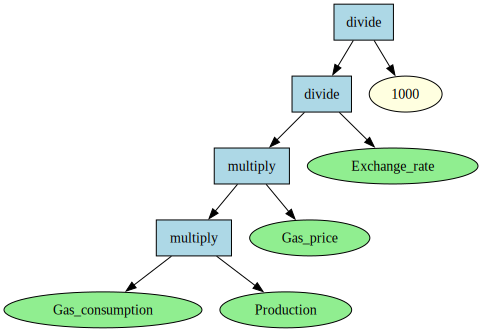

In [30]:
#| echo: false
from graphviz import Digraph

def create_graph(operation, graph=None, parent_id=None, node_counter=[0]):
    """Create graphviz visualization of operation tree"""
    if graph is None:
        graph = Digraph(comment='Formula Tree')
        graph.attr(rankdir='TB')
    
    current_id = str(node_counter[0])
    node_counter[0] += 1
    
    if isinstance(operation, Operation):
        # Create node for operation
        graph.node(current_id, operation.op_type, shape='box', style='filled', fillcolor='lightblue')
        
        if parent_id is not None:
            graph.edge(parent_id, current_id)
        
        # Add child nodes
        for operand in operation.operands:
            create_graph(operand, graph, current_id, node_counter)
    else:
        # Leaf node (variable or constant)
        color = 'lightgreen' if isinstance(operation, str) else 'lightyellow'
        graph.node(current_id, str(operation), shape='ellipse', style='filled', fillcolor=color)
        
        if parent_id is not None:
            graph.edge(parent_id, current_id)
    
    return graph

# Create visualization for Gas cost
gas_cost_graph = create_graph(parsed_formula)
gas_cost_graph.render('gas_cost_tree', format='png', cleanup=True)
gas_cost_graph

Now that we have some understanding on how `ast` works, let's start building towards our actual goal which is to translate parsed formulas into operations using our pandas dataframe. Instead of building from scratch, let's check if there are any libraries which already do what we need. One promising option is `formulas` library. Let's try it out.

In [116]:
import formulas
test_formula = "=Production*Netback_Price"
parsed = formulas.Parser().ast(test_formula)[1].compile()

context = {
    'PRODUCTION': mdl.loc['Production']['1Q 2032'],  # Test with one value first
    'NETBACK_PRICE': mdl.loc['Netback Price']['1Q 2032']
}
result = parsed(**context)
print(f"Formula result: {result}")
print(f"Expected: {mdl.loc['Revenue']['1Q 2032']}")

Formula result: 176069.03803415288
Expected: 176069.03803415288


Great, that worked. But unfortunately it runs like a `black box` and does not return the actual computations logic from the parsed formula. Maybe there is still a way to leverage `formulas` library for our purpose, but for now we will take a different approach.

We will progress in small steps and start with a simple test formula. The main parts of the code are basically the same:

* parse formula with `ast` keeping in mind naming conventions and
* recursively convert parsed formula names to original names and map `ast.operation` to python operations

In [120]:
#| code-fold: true
def parse_formula_to_pandas(formula_str, data_var='data'):
    """Convert 'Production*Netback Price' to '{data_var}.loc["Production"] * {data_var}.loc["Netback Price"]'"""
    
    # Replace spaces with underscores for parsing, but keep original names for lookup
    formula_clean = formula_str.replace(' ', '_')
    try:
        tree = ast.parse(formula_clean, mode='eval')
        return ast_to_pandas(tree.body, data_var)
    except Exception as e:
        print(f"Parse error: {e}")
        return None

def ast_to_pandas(node, data_var):
    if isinstance(node, ast.Name):
        # Convert variable name (with underscores) back to original (with spaces)
        original_name = node.id.replace('_', ' ')
        return f'{data_var}.loc["{original_name}"]'
    elif isinstance(node, ast.BinOp):
        left = ast_to_pandas(node.left, data_var)
        right = ast_to_pandas(node.right, data_var)
        op = {ast.Add: '+', ast.Sub: '-', ast.Mult: '*', ast.Div: '/'}[type(node.op)]
        return f'({left} {op} {right})'

Now to test our function:

In [122]:
formula = "Production*Netback Price"
result = parse_formula_to_pandas(formula)
print(f"Generated code: {result}")

Generated code: (data.loc["Production"] * data.loc["Netback Price"])


Great, we got the expected result. Now let's test our function on other formulas

In [131]:
test_formulas = [
    "Production*Netback Price",
    "Gas cost+Catalysts cost+Personnel cost+Current repairs cost", 
    "Revenue+Total Opex+Administrative cost",
    "EBITDA+Амортизация",
    "EBIT-Налог на EBIT",
    "-Gas consumption*Production*Gas price/Exchange rate/1000"
]

print("Testing formula parser:")
for formula in test_formulas:
    result = parse_formula_to_pandas(formula)
    print(f"\n'{formula}' -> {result}")

Testing formula parser:

'Production*Netback Price' -> (data.loc["Production"] * data.loc["Netback Price"])

'Gas cost+Catalysts cost+Personnel cost+Current repairs cost' -> (((data.loc["Gas cost"] + data.loc["Catalysts cost"]) + data.loc["Personnel cost"]) + data.loc["Current repairs cost"])

'Revenue+Total Opex+Administrative cost' -> ((data.loc["Revenue"] + data.loc["Total Opex"]) + data.loc["Administrative cost"])

'EBITDA+Амортизация' -> (data.loc["EBITDA"] + data.loc["Амортизация"])

'EBIT-Налог на EBIT' -> (data.loc["EBIT"] - data.loc["Налог на EBIT"])

'-Gas consumption*Production*Gas price/Exchange rate/1000' -> ((((-data.loc["Gas consumption"] * data.loc["Production"]) * data.loc["Gas price"]) / data.loc["Exchange rate"]) / 1000)


The last text example has failed because we need to account for unary minus operation (-Gas consumption) and for fixed values like 1000. Let's update our function

In [123]:
#| code-fold: true
def ast_to_pandas(node, data_var):
    if isinstance(node, ast.Name):
        # Convert variable name back to original (with spaces)
        original_name = node.id.replace('_', ' ')
        return f'{data_var}.loc["{original_name}"]'
    elif isinstance(node, ast.BinOp):
        left = ast_to_pandas(node.left, data_var)
        right = ast_to_pandas(node.right, data_var)
        op = {ast.Add: '+', ast.Sub: '-', ast.Mult: '*', ast.Div: '/'}[type(node.op)]
        return f'({left} {op} {right})'
    elif isinstance(node, ast.UnaryOp):
        if isinstance(node.op, ast.USub):
            # Handle unary minus
            operand = ast_to_pandas(node.operand, data_var)
            return f'-{operand}'
    elif isinstance(node, ast.Constant):
        return str(node.value)
    else:
        return None

In [134]:
#| echo: false
print("Testing formula parser:")
formula = test_formulas[-1]
result = parse_formula_to_pandas(formula)
print(f"\n'{formula}' -> {result}")

Testing formula parser:

'-Gas consumption*Production*Gas price/Exchange rate/1000' -> ((((-data.loc["Gas consumption"] * data.loc["Production"]) * data.loc["Gas price"]) / data.loc["Exchange rate"]) / 1000)


This is a good start, but we need to cover `If` statements as well, as they are very frequent in financial modelling. Once again, let's start with an example.

In [136]:
formula = "IF(EBIT<0,0,EBIT*Profit_Tax_Rate)"
tree = ast.parse(formula, mode='eval')
print(ast.dump(tree, indent=2))

Expression(
  body=Call(
    func=Name(id='IF', ctx=Load()),
    args=[
      Compare(
        left=Name(id='EBIT', ctx=Load()),
        ops=[
          Lt()],
        comparators=[
          Constant(value=0)]),
      Constant(value=0),
      BinOp(
        left=Name(id='EBIT', ctx=Load()),
        op=Mult(),
        right=Name(id='Profit_Tax_Rate', ctx=Load()))],
    keywords=[]))


We see that we also need to handle Lt() and Rt() operators in our code. Let's update it as follows.

In [137]:
#| echo: false
tree.body.args, tree.body.args[0].comparators

([<ast.Compare at 0x77fb6438b5d0>,
 [<ast.Constant at 0x77fb6438a350>])

In [138]:
#| code-fold: true
def ast_to_pandas(node, data_var):
    
    if isinstance(node, ast.Name):
        # Convert variable name back to original (with spaces)
        original_name = node.id.replace('_', ' ')
        return f'{data_var}.loc["{original_name}"]'
        
    elif isinstance(node, ast.BinOp):
        left = ast_to_pandas(node.left, data_var)
        right = ast_to_pandas(node.right, data_var)
        op = {ast.Add: '+', ast.Sub: '-', ast.Mult: '*', ast.Div: '/'}[type(node.op)]
        return f'({left} {op} {right})'

    elif isinstance(node, ast.Compare):
        # Handle comparisons < >
        comps = {ast.Lt: '<', ast.Gt: '>', ast.LtE: '<=', ast.GtE: '>=', ast.Eq: '==', ast.NotEq: '!='}
        comparisons = []
        left = ast_to_pandas(node.left, data_var)
        for op, comp in zip(node.ops, node.comparators):
            right = ast_to_pandas(comp, data_var)
            op_str = comps[type(op)]
            comparisons.append(f'{left} {op_str} {right}')
        return f'({" & ".join(comparisons)})'  # Use & for pandas boolean operations
        
    elif isinstance(node, ast.UnaryOp):
        if isinstance(node.op, ast.USub):
            # Handle unary minus
            operand = ast_to_pandas(node.operand, data_var)
            return f'-{operand}'
            
    elif isinstance(node, ast.Constant):
        return str(node.value)
        
    elif isinstance(node, ast.Call):
        # Handle function calls like IF, XIRR
        func_name = node.func.id
        args = [ast_to_pandas(arg, data_var) for arg in node.args]
        
        if func_name == 'IF':
            return f'np.where({args[0]}, {args[1]}, {args[2]})'
        elif func_name == 'XIRR':
            # XIRR(values, dates, guess) - Excel syntax
            return f'pyxirr.xirr({args[1]}, {args[0]})'
        else:
            return f'{func_name.lower()}({", ".join(args)})'
    else:
        return None

Let's give our new function a go on a conditional formula

In [148]:
test_if = "IF(EBIT<0,0,EBIT*Profit_Tax_Rate)"
result = parse_formula_to_pandas(test_if)
print(f"IF test: {result}")

IF test: np.where((data.loc["EBIT"] < 0), 0, (data.loc["EBIT"] * data.loc["Profit Tax Rate"]))


The formula is correct. Now to actually run it we just need to call `eval` and pass correct globals and locals.

In [150]:
eval(result, {"np": np, "pyxirr": pyxirr, "__builtins__": {}},  {'data': data})[50:55]

array([10701.764119534519, 10148.518734672218, 10768.607427076844, 10766.793295938105, 11087.418260043143], dtype=object)

Let's also run an IRR test

In [153]:
test_xirr = "XIRR(Итого FCFF,Timeline,0)"
result = parse_formula_to_pandas(test_xirr)
print(f"IRR test: {result}")
data.loc['IRR'].iloc[0]

IRR test: pyxirr.xirr(data.loc["Timeline"], data.loc["Итого FCFF"])


0.1484471533203125

Let's recap what we have achieved up till now.

**Initial Goal:**
Convert an Excel financial model into a Python calculation engine by translating text formula descriptions (like "Production*Netback Price") into executable pandas operations (like `mdl.loc['Production'] * mdl.loc['Netback Price']`).

**Steps Taken So Far:**

1. **Data Loading & Exploration:** Loaded Excel file into pandas DataFrame `mdl` with formulas in the 'Formula' column

2. **Library Evaluation:** Tested `formulas` library but found it created a "black box" - we wanted to extract the actual computational logic, not just execute it

3. **Custom AST Parser:** Built a parser using Python's `ast` module to convert formula strings into pandas code:
   - Handles basic operations: `+`, `-`, `*`, `/`
   - Handles unary minus: `-Gas consumption`
   - Handles numbers: `1000`
   - Handles comparisons: `EBIT < 0`
   - Handles Excel functions: `IF()` → `np.where()`, `XIRR()` → `pyxirr.xirr()`
<br><br>
4. **Execution Engine:** Created `execute_formula()` function to run the generated pandas code strings using `eval()`

5. **Testing:** Successfully tested with formulas like and verified results match original Excel calculations

**Current Status:** We have a working system that can parse different Excel formulas and convert them to executable pandas operations. Next steps would be handling more complex cases and building a complete calculation engine.